In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
from astropy.table import QTable
from scipy.interpolate import interp1d

from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import RingDustTorus

In [2]:
# tentative BB spectrum - this is what is drawn by agnpy by default
L_disk=4.7e11*const.L_sun *0.6
rdt=1*u.pc
dist=22*u.Mpc
Temp=500*u.K
z=Distance(dist).z
dt = RingDustTorus (L_disk=L_disk, T_dt=Temp, xi_dt=1., R_dt=rdt)
sed_unit="erg cm-2 s-1"
lamb_dt = np.logspace(2.5, -0.5)*u.um
nu_dt=(const.c/lamb_dt).to('Hz')
dt_sed = dt.sed_flux(nu=nu_dt, z=z)

In [3]:
# Rieke and Low 1975 points on NGC 1068 
# http://articles.adsabs.harvard.edu/full/1975ApJ...199L..13R
lamb_data = np.array([2.2, 3.6, 5.0, 8.4, 8.8, 10.4, 11.6, 12.6, 17, 19, 21, 22.5, 24.5, 33.5])*u.um
flux_data = np.array([0.3, 1.7, 5.3,12.9,12.7, 17.8, 26.9, 31.2, 54, 65, 66, 68,   78,   74.2])*u.Jy
flux_err  = np.array([0.1, 0.1, 0.5, 0.6, 0.6, 0.9,  1.3,  1.6,  6,  7,  7,  7,    8,    12])*u.Jy

nu_data=(const.c/lamb_data).to('Hz')
flux_data*=nu_data
flux_err*=nu_data

flux_data=flux_data.to(sed_unit)
flux_err=flux_err.to(sed_unit)

In [4]:
# model from Pier & Krolik 1993 paper
pk93_table=QTable.read(
    'agnpy/data/dt_seds/pier_krolik_1993.txt', 
    format='ascii'
)
lamb_pk93=np.array(pk93_table['col1'])*u.um
nu_pk93=(const.c/lamb_pk93).to('Hz')
sed_pk93=(np.array(pk93_table['col2'])*u.Unit('Jy/um')*const.c).to(sed_unit)

interp = interp1d(lamb_pk93, sed_pk93)

In [5]:
# now try to simulate it by a bunch of BB spectra
# no fit is done, just the emission at a given temperature 
# is set proportional to emission at the corresponding wavelength
nbb=20
lamb_min=3
lamb_max=30
lambs = np.logspace(np.log10(lamb_min), np.log10(lamb_max),nbb)*u.um
lamb0 = lamb_dt[np.argmax(dt_sed)]
Temps=Temp * lamb0/lambs
Lums=interp(lambs)
Lums=Lums *L_disk / sum(Lums)
dts =np.empty(len(Temps), dtype=RingDustTorus)
dt_seds=np.empty((len(nu_dt), len(Temps)), dtype=u.Quantity)
for i in range(len(Temps)):
    dts[i] = RingDustTorus (L_disk=Lums[i], T_dt=Temps[i], xi_dt=1., R_dt=rdt)
    dt_seds[:,i] = dts[i].sed_flux(nu=nu_dt, z=z)
dt_seds_sum=np.sum(dt_seds, axis=1)
print(Temps)

[1171.62201922 1037.90103774  919.44206107  814.50318761  721.54132458
  639.18949736  566.23674849  501.61033099  444.35993395  393.64370848
  348.7158886   308.915825    273.6582704   242.42477366  214.75605616
  190.24525819  168.53195627  149.29686318  132.257133    117.16220192] K


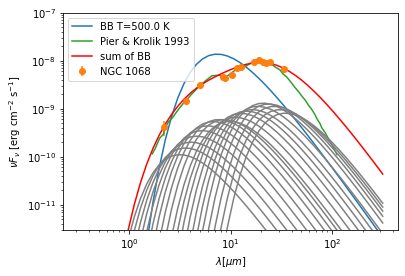

In [6]:
plt.plot(lamb_dt, dt_sed, label=f"BB T={Temp}")
plt.errorbar(lamb_data.value, flux_data.value, marker='o', linestyle='', yerr=flux_err.value, label='NGC 1068')
plt.plot(lamb_pk93, sed_pk93, label='Pier & Krolik 1993')
for i in range(len(Temps)):
    plt.plot(lamb_dt, dt_seds[:,i], color='gray')
plt.plot(lamb_dt, dt_seds_sum, color='r', label='sum of BB') 
plt.ylim(3.e-12, 1.e-7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\lambda[\mu m]$")
plt.ylabel(r"$\nu F_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]")
plt.legend()

In [7]:
# now compute the IC emission
#first define some dummy blob
norm = 1.5e5 * u.Unit("cm-3")
parameters1 = {
    "p1": 2.0,
    "p2": 3.9,
    "gamma_b": 300.,
    "gamma_min": 2.5,
    "gamma_max": 3.e4,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters1}
R_b = 1.e16 * u.cm
B = 1. * u.G
delta_D = 20
Gamma = 17
dist_in=0.3*u.pc
blob = Blob(R_b, z, delta_D, Gamma, B, norm, spectrum_dict)
blob.set_gamma_size(500)

#and compute the SED from EC
nu_ec = np.logspace(15, 30) * u.Hz
ec_dt = ExternalCompton(blob, dt, dist_in)
ec_dt_sed = ec_dt.sed_flux(nu_ec)

In [8]:
#now do the same with a bunch of DT components
ec_dt_seds=np.empty((len(nu_ec), len(Temps)), dtype=u.Quantity)
for i in range(len(Temps)):
    ec_dt = ExternalCompton(blob, dts[i], dist_in)
    ec_dt_seds[:,i] = ec_dt.sed_flux(nu_ec)
ec_dt_seds_sum=np.sum(ec_dt_seds, axis=1)

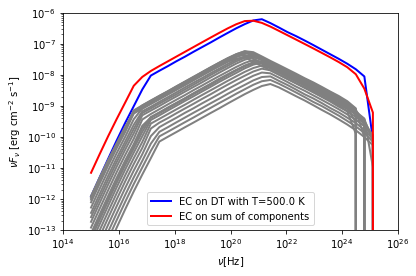

In [9]:
plt.loglog(nu_ec, ec_dt_sed, lw=2, ls='-', color="b", label=f"EC on DT with T={Temp}")
for i in range(len(Temps)):
    plt.loglog(nu_ec, ec_dt_seds[:,i], lw=2, ls='-', color="gray")
plt.loglog(nu_ec, ec_dt_seds_sum, lw=2, ls='-', color="r", label=f"EC on sum of components")    
plt.ylim(1e-13, 1e-6)
plt.xlim(1e14, 1e26)
plt.xlabel(r"$\nu$[Hz]")
plt.ylabel(r"$\nu F_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]")
plt.legend(ncol=1)
plt.show()